# <a>Project 2 - Machine Learning - Recommendation System</a>

## Let's Data - Data Science Journey - Data Science Experience

*By Reginaldo Jr - <a>reginaldojr@yahoo.com</a>*

### Imports and Configurations

In [33]:
import pandas as pd
import warnings 
import numpy as np
import seaborn as sns
import pickle as pkl
import random

from scipy.sparse import csr_matrix
from matplotlib import pyplot
from sklearn.neighbors import NearestNeighbors
from IPython.display import HTML

warnings.filterwarnings("ignore")

sns.set_style("darkgrid")

pd.set_option("display.float_format", lambda x: "%.2f" % x)
pd.set_option("display.max_rows", None)
#pd.set_option("display.max_columns", None)

### Data

In [2]:
books_df = pd.read_csv("Books.csv")
books_df.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


In [3]:
ratings_df = pd.read_csv("Ratings.csv")
ratings_df.head()

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [4]:
users_df = pd.read_csv("Users.csv")
users_df.head()

,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.00
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.00
4,5,"farnborough, hants, united kingdom",NaN


In [5]:
books_df = books_df[["ISBN", "Book-Title","Book-Author", "Image-URL-M"]].rename(columns={"ISBN":"isbn","Book-Title":"title","Book-Author":"author", "Image-URL-M":"image"})
books_df.head()

,isbn,title,author,image
0,0195153448,Classical Mythology,Mark P. O. Morford,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,http://images.amazon.com/images/P/0393045218.0...


In [7]:
books_df["image"].head()

0    http://images.amazon.com/images/P/0195153448.0...
1    http://images.amazon.com/images/P/0002005018.0...
2    http://images.amazon.com/images/P/0060973129.0...
3    http://images.amazon.com/images/P/0374157065.0...
4    http://images.amazon.com/images/P/0393045218.0...
Name: image, dtype: object

In [8]:
books_df.shape

(271360, 4)

In [9]:
ratings_df = ratings_df.rename(columns={"User-ID":"userId","ISBN":"isbn","Book-Rating":"rating"})
ratings_df.head()

,userId,isbn,rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [10]:
ratings_df.shape

(1149780, 3)

### EDA

In [11]:
ratings_df.describe()

,userId,rating
count,1149780.00,1149780.00
mean,140386.40,2.87
std,80562.28,3.85
min,2.00,0.00
25%,70345.00,0.00
50%,141010.00,0.00
75%,211028.00,7.00
max,278854.00,10.00


In [12]:
ratings_df["rating"].value_counts().sort_index()

rating
0     716109
1       1770
2       2759
3       5996
4       8904
5      50974
6      36924
7      76457
8     103736
9      67541
10     78610
Name: count, dtype: int64

<Axes: xlabel='rating', ylabel='Count'>

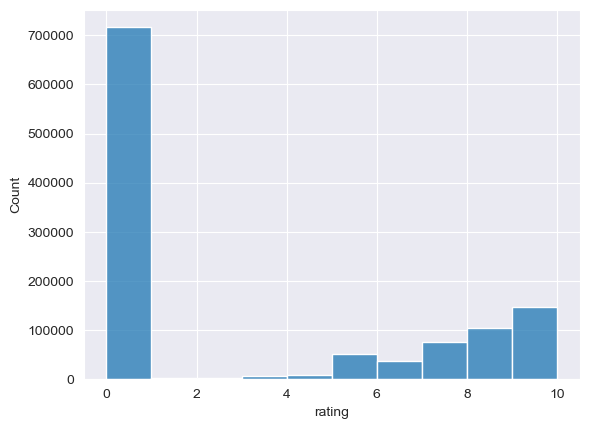

In [13]:
sns.histplot(data=ratings_df, x="rating", bins=10)

In [14]:
books_ratings_df = books_df.merge(ratings_df, on="isbn")
books_ratings_df.head()

,isbn,title,author,image,userId,rating
0,0195153448,Classical Mythology,Mark P. O. Morford,http://images.amazon.com/images/P/0195153448.0...,2,0
1,0002005018,Clara Callan,Richard Bruce Wright,http://images.amazon.com/images/P/0002005018.0...,8,5
2,0002005018,Clara Callan,Richard Bruce Wright,http://images.amazon.com/images/P/0002005018.0...,11400,0
3,0002005018,Clara Callan,Richard Bruce Wright,http://images.amazon.com/images/P/0002005018.0...,11676,8
4,0002005018,Clara Callan,Richard Bruce Wright,http://images.amazon.com/images/P/0002005018.0...,41385,0


In [15]:
books_ratings_df.groupby(["isbn","title"])["rating"].agg(["mean"]).reset_index().sort_values(by="mean", ascending=False).head(10)

,isbn,title,mean
231152,1575848236,To The Rescue (Move and Play),10.00
24662,0195061659,Prometheus Bound (Greek Tragedy in New Transla...,10.00
195985,0871359057,Dinosaurs: A Celebration,10.00
195986,0871359243,Dinosaurs: A Celebration,10.00
195987,0871359251,Dinosaurs: A Celebration,10.00
222211,1559639407,Fatal Harvest: The Tragedy of Industrial Agric...,10.00
24674,0195065107,The Oxford Companion to African American Liter...,10.00
195989,0871400332,Expressionism In Art,10.00
65191,0380763796,Tons of Trash: Why You Should Recycle and What...,10.00
11117,0062733834,Alt. Culture: An A-To-Z Guide to the '90S-Unde...,10.00


In [16]:
books_ratings_df.groupby(["isbn","title"])["rating"].agg(["mean"]).reset_index().sort_values(by="mean").head(10)

,isbn,title,mean
135075,0671499173,Winner Circle,0.00
144938,0679757651,The Circle of Innovation,0.00
144945,0679757961,Life Estates,0.00
144946,0679758283,Indoor Gardening: Chicago Botanic Garden (The ...,0.00
144948,0679758348,The Lost Children of Wilder: The Epic Struggle...,0.00
144949,0679758372,Book of Color (Vintage International (Paperback)),0.00
144954,0679758542,Watch With Me: And Six Other Stories of the Ye...,0.00
144956,067975864X,The Gospel of Life: Evangelium Vitae (Random H...,0.00
144933,0679756949,Brothers and Keepers,0.00
144958,0679758771,Dance for Two: Selected Essays,0.00


In [17]:
books_ratings_df.groupby(["isbn","title"])["rating"].agg(["count"]).reset_index().sort_values(by="count", ascending=False).head(10)

,isbn,title,count
215952,0971880107,Wild Animus,2502
38570,0316666343,The Lovely Bones: A Novel,1295
70798,0385504209,The Da Vinci Code,883
7344,0060928336,Divine Secrets of the Ya-Ya Sisterhood: A Novel,732
32370,0312195516,The Red Tent (Bestselling Backlist),723
87397,044023722X,A Painted House,647
21342,0142001740,The Secret Life of Bees,615
145042,067976402X,Snow Falling on Cedars,614
133142,0671027360,Angels &amp; Demons,586
93847,0446672211,Where the Heart Is (Oprah's Book Club (Paperba...,585


In [18]:
df = books_ratings_df.merge(ratings_df.groupby("isbn")["rating"].agg(["count"]).reset_index().sort_values(by="count",ascending=False),on="isbn")
df.head()

,isbn,title,author,image,userId,rating,count
0,0195153448,Classical Mythology,Mark P. O. Morford,http://images.amazon.com/images/P/0195153448.0...,2,0,1
1,0002005018,Clara Callan,Richard Bruce Wright,http://images.amazon.com/images/P/0002005018.0...,8,5,14
2,0002005018,Clara Callan,Richard Bruce Wright,http://images.amazon.com/images/P/0002005018.0...,11400,0,14
3,0002005018,Clara Callan,Richard Bruce Wright,http://images.amazon.com/images/P/0002005018.0...,11676,8,14
4,0002005018,Clara Callan,Richard Bruce Wright,http://images.amazon.com/images/P/0002005018.0...,41385,0,14


In [19]:
#del (books_df)
del (ratings_df)
del (users_df)
del (books_ratings_df)

### Missing Data

In [20]:
df.isnull().sum()

isbn      0
title     0
author    2
image     0
userId    0
rating    0
count     0
dtype: int64

In [21]:
df = df.dropna()
df.isnull().sum()

isbn      0
title     0
author    0
image     0
userId    0
rating    0
count     0
dtype: int64

### Limiting Ratings

In [22]:
df.shape

(1031134, 7)

In [23]:
limit_rating = 50
df.query("count>=@limit_rating").shape

(234876, 7)

In [24]:
df = df.query("count>=@limit_rating").sort_values(by="count",ascending=False)
len(df["title"].unique())

1964

In [25]:
df.head()

,isbn,title,author,image,userId,rating,count
2506,0971880107,Wild Animus,Rich Shapero,http://images.amazon.com/images/P/0971880107.0...,196047,0,2502
2205,0971880107,Wild Animus,Rich Shapero,http://images.amazon.com/images/P/0971880107.0...,161068,1,2502
2231,0971880107,Wild Animus,Rich Shapero,http://images.amazon.com/images/P/0971880107.0...,164105,0,2502
2232,0971880107,Wild Animus,Rich Shapero,http://images.amazon.com/images/P/0971880107.0...,164315,6,2502
2233,0971880107,Wild Animus,Rich Shapero,http://images.amazon.com/images/P/0971880107.0...,164533,0,2502


In [26]:
df = df.pivot_table(index="title", columns="userId", values="rating", fill_value=0)

In [27]:
df.head()

userId,9,14,16,17,26,32,39,42,44,51,...,278813,278819,278828,278832,278836,278843,278844,278846,278851,278854
title,,,,,,,,,,,,,,,,,,,,,
16 Lighthouse Road,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1984,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1st to Die: A Novel,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2010: Odyssey Two,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
204 Rosewood Lane,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


 ### Model Fit

In [28]:
df_matrix = csr_matrix(df.values)
df_matrix

<1964x42828 sparse matrix of type '<class 'numpy.float64'>'
	with 93610 stored elements in Compressed Sparse Row format>

In [29]:
model = NearestNeighbors(metric="cosine")
model.fit(df_matrix)

NearestNeighbors(metric='cosine')

### Test

In [32]:
len(df.index)

1964

In [30]:
df.loc[df.index.str.contains("Harry Potter")].index

Index(['Harry Potter and the Chamber of Secrets (Book 2)',
       'Harry Potter and the Goblet of Fire (Book 4)',
       'Harry Potter and the Order of the Phoenix (Book 5)',
       'Harry Potter and the Prisoner of Azkaban (Book 3)',
       'Harry Potter and the Sorcerer's Stone (Book 1)',
       'Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback))'],
      dtype='object', name='title')

In [37]:
pos = df.index.get_loc("Harry Potter and the Sorcerer's Stone (Book 1)")
pos

627

In [38]:
df.index[pos]

"Harry Potter and the Sorcerer's Stone (Book 1)"

In [39]:
df.iloc[pos,:].values

array([0., 0., 0., ..., 0., 0., 0.])

In [44]:
distance, indices = model.kneighbors([df.iloc[pos,:].values], n_neighbors=6)
distance, indices

(array([[1.66533454e-15, 6.25800439e-01, 6.29351577e-01, 6.36224359e-01,
         7.45391076e-01, 8.61691194e-01]]),
 array([[ 627,  623,  626,  624,  625, 1531]], dtype=int64))

In [45]:
for i,b in enumerate(indices.flatten()):
    if i==0:
        print(f"Recomendation for {df.index[pos]}:")
    else:
        url = books_df.loc[books_df["title"]==df.index[b],"image"].values[0]
        print (f"{i}: {df.index[b]}, distance: {distance.flatten()[i]}")
        display(HTML(f'<img src="{url}"/>'))
    

Recomendation for Harry Potter and the Sorcerer's Stone (Book 1):
1: Harry Potter and the Chamber of Secrets (Book 2), distance: 0.6258004386107232


2: Harry Potter and the Prisoner of Azkaban (Book 3), distance: 0.6293515771074749


3: Harry Potter and the Goblet of Fire (Book 4), distance: 0.6362243589522747


4: Harry Potter and the Order of the Phoenix (Book 5), distance: 0.7453910756400858


5: The Hobbit: or There and Back Again, distance: 0.8616911944642508


In [51]:
pos = random.randint(0,len(df)-1)
distance, indices = model.kneighbors([df.iloc[pos,:].values], n_neighbors=6)
for i,b in enumerate(indices.flatten()):
    if i==0:
        print(f"Recomendation for {df.index[pos]}:")
    else:
        url = books_df.loc[books_df["title"]==df.index[b],"image"].values[0]
        print (f"{i}: {df.index[b]}, distance: {distance.flatten()[i]}")
        display(HTML(f'<img src="{url}"/>'))

Recomendation for And Then You Die:
1: The Face of Deception, distance: 0.8484050362997013


2: Long After Midnight, distance: 0.8871598972654738


3: The Tailor of Panama, distance: 0.8871692280054445


4: Stanislaski Sisters, distance: 0.8928331620496908


5: The Search, distance: 0.8937843833157995


### Deploy

In [50]:
with open("model.pkl", 'wb') as model_file, open("books_df.pkl", 'wb') as books_file, open("books_user.pkl", "wb") as books_user_file:
    pkl.dump(model, model_file)
    pkl.dump(books_df, books_file)
    pkl.dump(df, books_user_file)